# Лабораторная 5. Частотная фильтрация

# Частотная фильтрация.

- Для частотной фильтрации использовать БПФ (средствами OpenCV)

- Показать пошаговое применение частотных сглаживающих и повышающих резкость фильтров:

- Показать в сравнении идеальный фильтр, Батерворта и гауссиан

# Что нужно показывать!!!

- Исходное изображение.
- Спектр изображения
- Частотный фильтр для сглаживания
- Результат наложения в виде спектра и в виде изображения
- Частотный фильтр для повышения резкости
- Результат наложения в виде спектра и в виде изображения

In [1]:
from io import BytesIO
from skimage import io
from PIL import Image, ImageDraw
from skimage import img_as_float
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline 
import math

### Функция вывода изображения

In [2]:
def showImage(images, size = 20, countInRow=2, countInCol=2, colorMap = 'gray'):
    countImages = len(images)
    #size *= countImages
    pic_box = plt.figure(figsize=(size, size))
    for i, image in enumerate(images):
        pic_box.add_subplot(countInRow, countInCol, i+1)
        plt.imshow(image)
        plt.set_cmap(colorMap)
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.axis('off')
    plt.show()

### Функция сдвига

In [3]:
def get_dft_fftshift(image: np.ndarray):
    image_dft = cv2.dft(np.float32(image), flags = cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(image_dft)

### Функция для спектра изображения

In [4]:
def get_spectrum(image: np.ndarray, const = 0):
    image_fftshift = get_dft_fftshift(image)
    magnitude = cv2.magnitude(image_fftshift[:,:,0], image_fftshift[:,:,1])
    return np.log(magnitude + const)

### Функция нахождения расстояния между точками

In [5]:
def get_distance(a, b, c, d):
    return math.sqrt((a - c) * (a - c) + (b - d) * (b - d))

### Функция dft(inverse) и magnitude

In [6]:
def get_dft_inverse_magnitude(image: np.ndarray):
    inverse_dft = cv2.dft(image, cv2.DFT_INVERSE)   
    return cv2.magnitude(inverse_dft[:,:, 0], inverse_dft[:,:, 1])

# Функция формирует список фото(маска, результат фильтрации маски, спекст)

In [7]:
def get_list_images(image_dft_shift, mask, constForSpectrum=0):
    result = []
    filtered_mask = image_dft_shift * mask # фильрация изображения
    result.append(cv2.magnitude(mask[:,:,0], mask[:,:,1]))
    result.append(get_dft_inverse_magnitude(filtered_mask)) # применение фильра
    result.append(get_spectrum(result[1], constForSpectrum)) # спектр измененного фото
    return result

## Исходное изображение.

In [8]:
image_srs= cv2.imread('3.jpg', 0)

## Спектр исходного изображения

In [9]:
image_srs_spectrum = get_spectrum(image_srs)

## Исходное изображение и его спектр

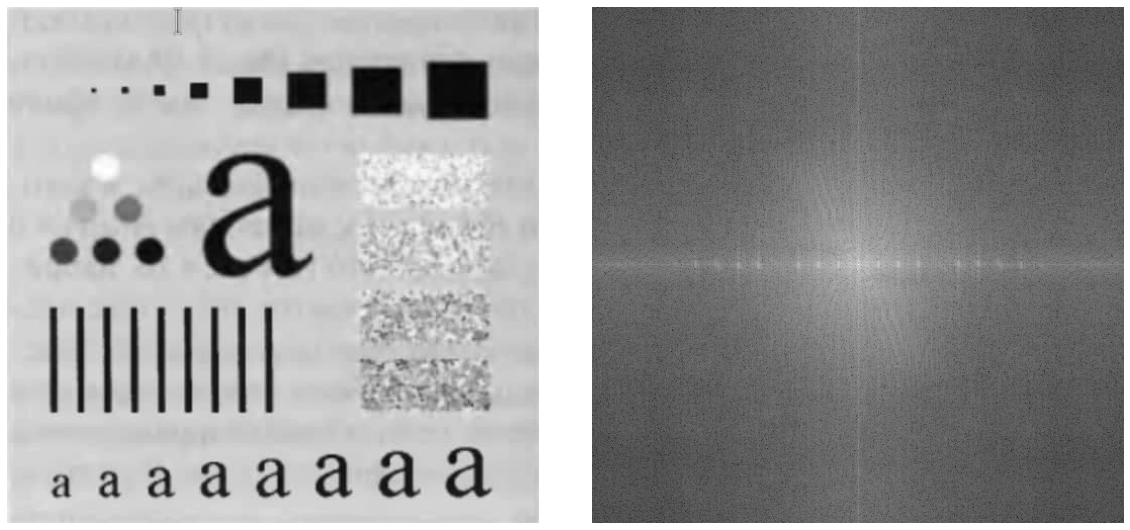

In [10]:
showImage([image_srs, image_srs_spectrum])

# Идеальные фильтры низких частот (ИФНЧ)

In [11]:
width, height = image_srs.shape

In [12]:
image_dft_shift = get_dft_fftshift(image_srs)

###### Формула вычисления идеального фильтра

In [13]:
mask_perfect_low = np.zeros((width, height, 2))

d = 30

for i in range(width):
    for j in range(height):
        distance = int(get_distance(i, j, width / 2, height / 2) <= d)
        mask_perfect_low[i][j][0], mask_perfect_low[i][j][1]  = distance, distance



filtrated_perfect_low = image_dft_shift * mask_perfect_low

mask_perfect_low_magnitude = cv2.magnitude(mask_perfect_low[:,:,0], mask_perfect_low[:,:,1])
filtrated_perfect_low_magnitude = get_dft_inverse_magnitude(filtrated_perfect_low)
filtrated_perfecte_low_spectrum = get_spectrum(filtrated_perfect_low_magnitude, const=0.001)

showImage([image_srs, 
           mask_perfect_low_magnitude, 
           filtrated_perfect_low_magnitude, 
           filtrated_perfecte_low_spectrum],
         countInRow=1,
         countInCol=4)

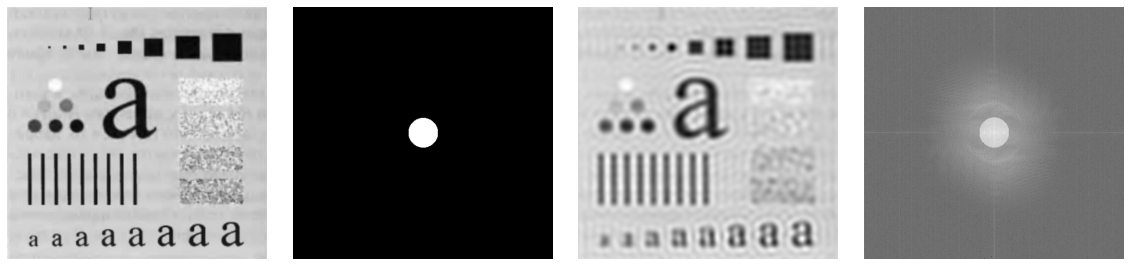

In [14]:
result_pefect_low = get_list_images(image_dft_shift, mask_perfect_low, constForSpectrum=0.0001)

showImage([image_srs, *result_pefect_low], 
          countInRow=1,
          countInCol=4)

In [15]:
mask_perfect_revers = 1 - mask_perfect_low

In [16]:
mask_perfect_revers = 1 - mask_perfect_low
filtrated_perfect_revers = image_dft_shift * mask_perfect_revers
filtrated_perfect_revers_magnitude = get_dft_inverse_magnitude(filtrated_perfect_revers)
filtrated_perfect_revers_magnitude_spectrum = get_spectrum(filtrated_perfect_revers_magnitude)

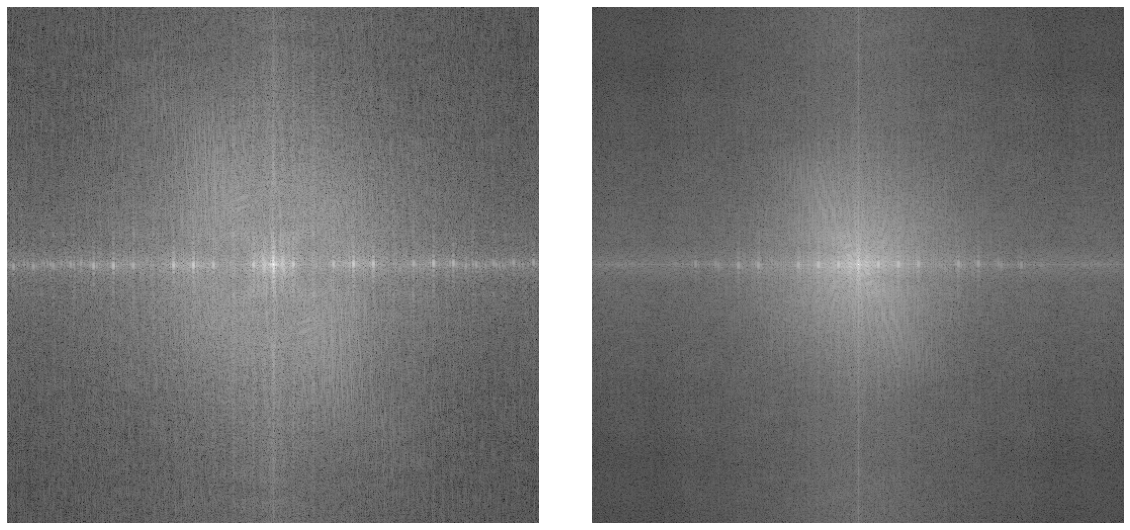

In [17]:
showImage([filtrated_perfect_revers_magnitude_spectrum, 
           image_srs_spectrum])

# Фильтры низких частот Баттерворта (БФНЧ)

###### Формула вычисления низких частот Баттерворта

In [18]:
width, height = image_srs.shape
mask_Butterworth_low = np.zeros((width, height ,2))
d = 30 
n = 20

for i in range(width):
    for j in range(height):
        value = 1.0 / (1 + (get_distance(i, j, width/2, height/2) / d) ** (2 * n))
        mask_Butterworth_low[i][j][0], mask_Butterworth_low[i][j][1] = value, value
        

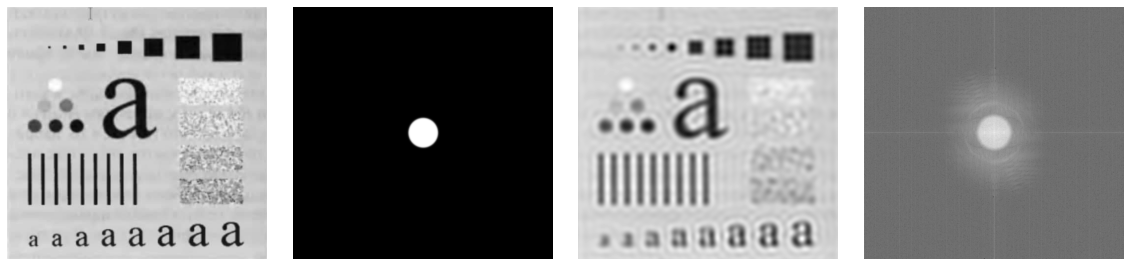

In [19]:
result_Butterworth_low = get_list_images(image_dft_shift, mask_Butterworth_low, constForSpectrum=0.0001)

showImage([image_srs, *result_Butterworth_low], 
          countInRow=1,
          countInCol=4)

# Фильтры высоких частот Баттерворта (БФНЧ)

###### Формула вычисления высоких частот Баттерворта

In [20]:
mask_Butterworth_hight = np.zeros((width, height, 2))
d = 15
n = 2

for i in range(width):
    for j in range(height):
        value = 1 / (1 + (get_distance(i, j, width/2, height/2) / d) ** (2 * n))
        mask_Butterworth_hight[i][j][0], mask_Butterworth_hight[i][j][1] = value, value

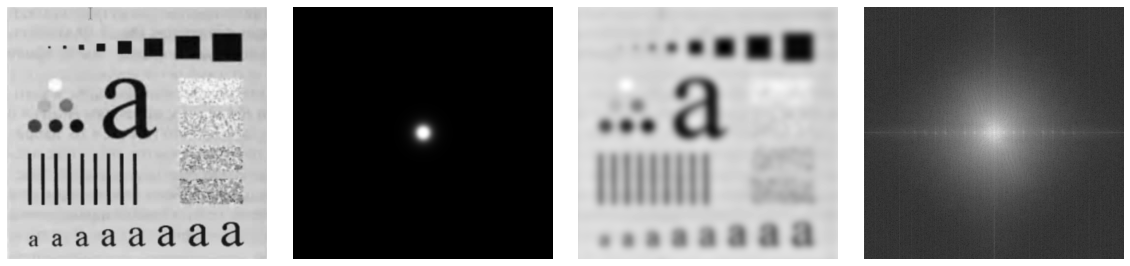

In [21]:
result_Butterworth_hight = get_list_images(image_dft_shift, mask_Butterworth_hight, constForSpectrum=0.0001)

showImage([image_srs, *result_Butterworth_hight], 
          countInRow=1,
          countInCol=4)

# Фильтры низких частот Гауса (ГФНЧ)

###### Формула вычисления низких частот Гауса

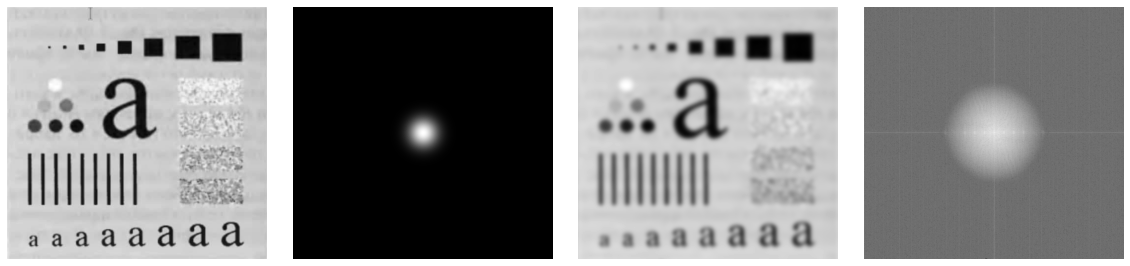

In [24]:
mask_Gauss_low = np.zeros((width, height ,2))
d = 20 

for i in range(width):
    for j in range(height):
        value = math.exp(-(get_distance(i, j, width/2, height/2) ** 2) / (2*d*d))
        mask_Gauss_low[i][j][0], mask_Gauss_low[i][j][1] = value, value
        
result_Gauss_low = get_list_images(image_dft_shift, mask_Gauss_low, constForSpectrum=0.0001)

showImage([image_srs, *result_Gauss_low], 
          countInRow=1,
          countInCol=4)

# Фильтры высоких частот Гауса (ГФНЧ)

# Формула вычисления низких частот Гауса

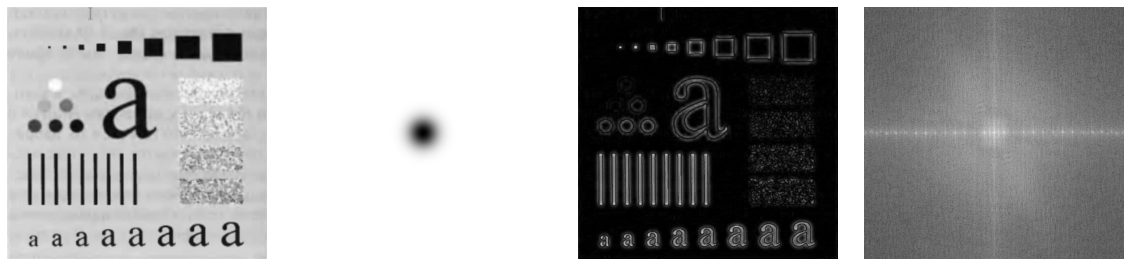

In [23]:
mask_Gauss_hight = 1 - mask_Gauss_low
result_Gauss_hight = get_list_images(image_dft_shift, mask_Gauss_hight, constForSpectrum=0.0001)

showImage([image_srs, *result_Gauss_hight], 
          countInRow=1,
          countInCol=4)